# Small machine learning project
### Data cleaning, descriptive analysis, PCA, clustering, CART

_____________________________________________________________________________________________________________________
### Author: Maria Bugge
April 2019

The dataset used is based on pregnant women's characteristics, and the purpose here is to predict whether the future mom will experience sickness or not

In [2]:
#Set-up

library(ggplot2)
library(reshape2)
library(cluster)
library('HSAUR')
library("scatterplot3d")
library('purrr')
library(caretEnsemble)
library("rpart")
library("randomForest")
library(dplyr)

options(repr.plot.width=7, repr.plot.height=5)

In [3]:
#Import data
df_raw<-read.csv('First_dataset.csv')

In [4]:
head(df_raw)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


###  Cleaning the data set 

In [25]:
str(df_raw)

'data.frame':	768 obs. of  11 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 115 197 125 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 0 70 96 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 0 543 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ Outcome                 : int  1 0 1 0 1 0 1 0 1 1 ...
 $ agecategory             : num  3 2 2 1 2 2 2 2 3 3 ...
 $ preg_cat                : num  6 1 7 1 0 5 3 7 2 7 ...


In [26]:
#Step 1: converting to correct format
df_raw$Pregnancies<-as.numeric(df_raw$Pregnancies)
df_raw$Glucose<-as.numeric(df_raw$Glucose)
df_raw$BloodPressure<-as.numeric(df_raw$BloodPressure)
df_raw$SkinThickness<-as.numeric(df_raw$SkinThickness)
df_raw$Insulin<-as.numeric(df_raw$Insulin)
df_raw$Age<-as.numeric(df_raw$Age)
df_raw$Outcome<-as.factor(df_raw$Outcome)

In [27]:
#Step 2: checking for missing values
length(which(is.na(df_raw)))

[1] 0

In [28]:
#Step 3: Looking for inconsistencies (e.g. negative age values)
#Actually any negative value would be inconsistent
has_neg_val <- apply(df_raw[,c(1:8)], 1, function(row) any(row < 0))
length(which(has_neg_val)) #no negative values: no inconsistencies

[1] 0

In [29]:
#Step 4: replacing the zeros in Insulin, BMI, SkinThickness, Glucose and BloodPressure in the means of the 
#respective variables
df_raw$Insulin[df_raw$Insulin==0]<-mean(df_raw$Insulin)
df_raw$BMI[df_raw$BMI==0]<-mean(df_raw$BMI)
df_raw$SkinThickness[df_raw$SkinThickness==0]<-mean(df_raw$SkinThickness)
df_raw$Glucose[df_raw$Glucose==0]<-mean(df_raw$Glucose)
df_raw$BloodPressure[df_raw$BloodPressure==0]<-mean(df_raw$BloodPressure)


Now that we have verified the data is clean, let's explore it

### Statistical descriptive analysis 

Let's look at the different values and possible correlations


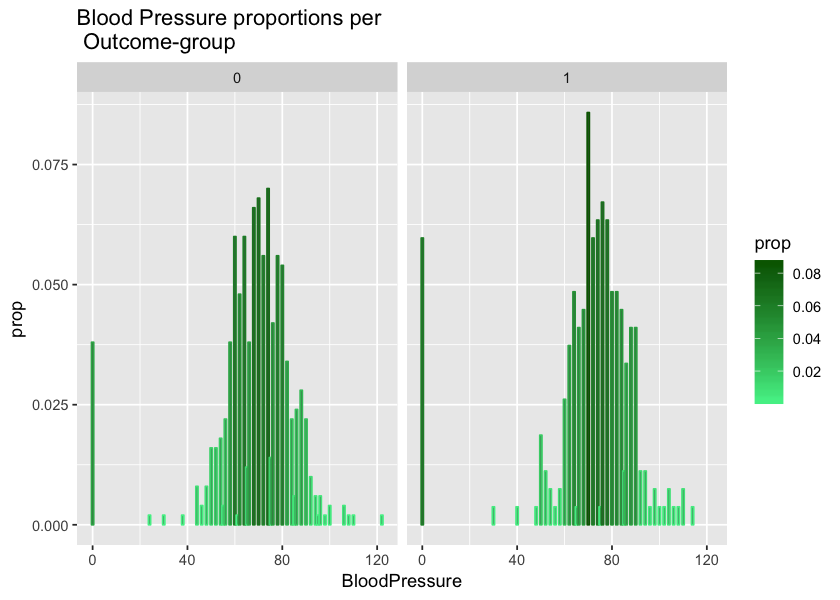

In [5]:
ggplot(df_raw,aes(x=BloodPressure,y=..prop..,color=..prop..)) + geom_bar() + facet_wrap(~Outcome) +
    scale_color_gradient(low="seagreen2", high="darkgreen") + ggtitle("Blood Pressure proportions per \n Outcome-group")



The distribution of Blood Pressure per outcome-group is quite similar, except for Blood Pressure value of approximately 70 where a high proportion is sick. 

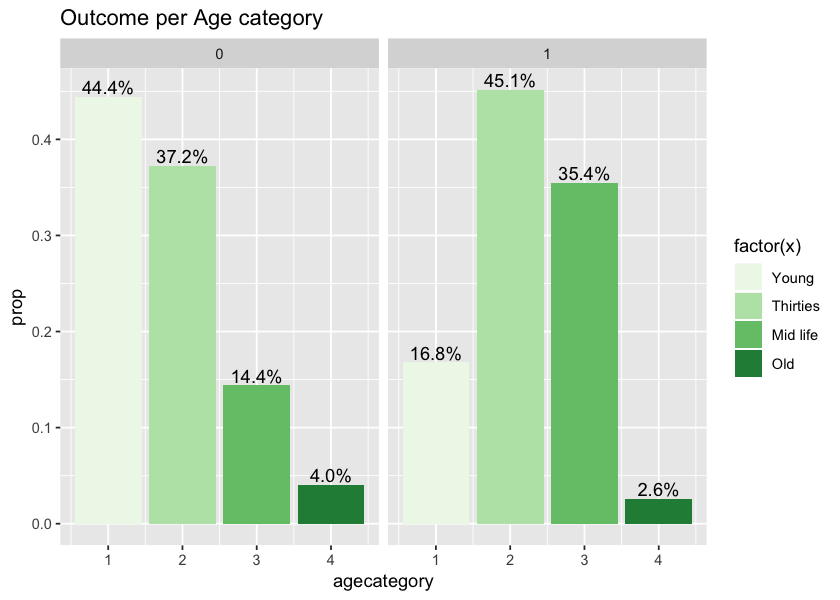

In [6]:
#Dividing the ages into categories to analyze the proportions of sickness per age group. 
df_raw$agecategory[df_raw$Age<=25]<-1 #young
df_raw$agecategory[df_raw$Age>25 & df_raw$Age<=40]<-2 #thirties
df_raw$agecategory[df_raw$Age>40 & df_raw$Age<=60]<-3 #mid-life
df_raw$agecategory[df_raw$Age>60]<-4 #old

ggplot(df_raw,aes(x=agecategory,y=..prop..,fill=factor(..x..))) + geom_bar() + facet_wrap(~Outcome) +
    scale_fill_brewer(palette="Greens",labels=c("Young","Thirties","Mid life","Old")) +
    geom_text(aes(label = scales::percent(..prop..),y= ..prop..), stat="count",vjust = -.25) +
    ggtitle("Outcome per Age category")



From the figure above we obesrve that there are two age categories that stand out: "young" and "mid-life". Indeed, for "thirties" and "old" the difference in proportion per outcome-group is not obvious, whereas it is for "young" and "mid-life". We can see that for young people (<25), the proportion of those who were sick is pretty small compared to the proportion of non-sick. On the contrary, for mid-life people the proportion of people who were sick is big compared to the proportion of people who were *not* sick.

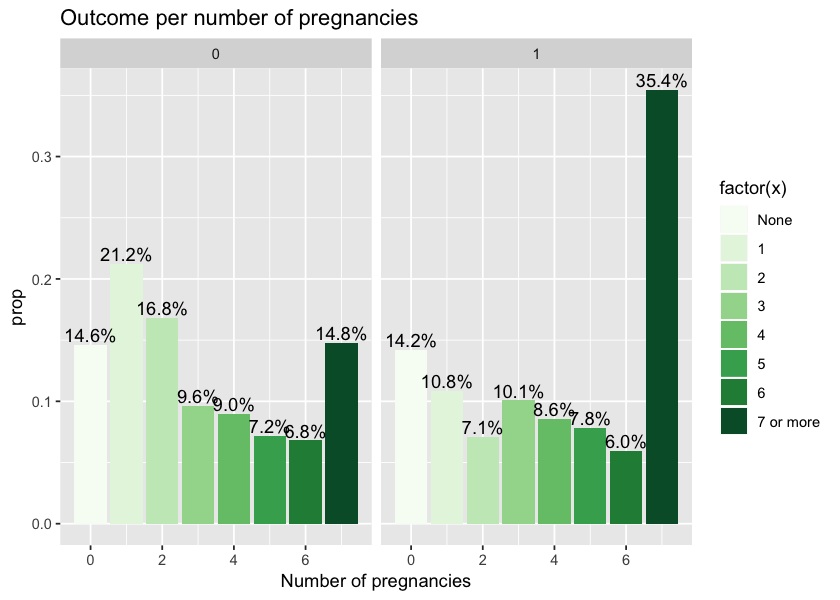

In [7]:
#Histogram based on pregnancies per outcome groupe
#All over 6 pregnancies is a lot --> creation of a categorical pregnancy variable 
df_raw$preg_cat[df_raw$Pregnancies==0]<-0
df_raw$preg_cat[df_raw$Pregnancies==1]<-1;df_raw$preg_cat[df_raw$Pregnancies==2]<-2
df_raw$preg_cat[df_raw$Pregnancies==3]<-3;df_raw$preg_cat[df_raw$Pregnancies==4]<-4
df_raw$preg_cat[df_raw$Pregnancies==5]<-5;df_raw$preg_cat[df_raw$Pregnancies==6]<-6
df_raw$preg_cat[df_raw$Pregnancies>6]<-7

ggplot(df_raw,aes(x=preg_cat,y=..prop..,fill=factor(..x..))) + geom_bar() + facet_wrap(~Outcome) +
    scale_fill_brewer(palette="Greens",labels=c("None","1","2","3","4","5","6","7 or more")) +
    geom_text(aes(label = scales::percent(..prop..),y= ..prop..), stat="count",vjust = -.25) +
    ggtitle("Outcome per number of pregnancies") + xlab("Number of pregnancies")


The distribution amongst 0 to 6 pregnancies is quite similar, except for a higher proportion of non-sick women who have been pregnant once. However, for women having been pregnant 7 times or more, there is a very high proportion of sickness. 

In [14]:
print(df_raw %>% filter(Outcome==1) %>% summarize(median_glucose=median(Glucose),mean_glucose=mean(Glucose)))

  median_glucose mean_glucose
1            140     141.2575


Outcome,variable,value
0,Glucose,107.00
1,Glucose,140.00
0,BMI,30.05
1,BMI,34.25


No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()


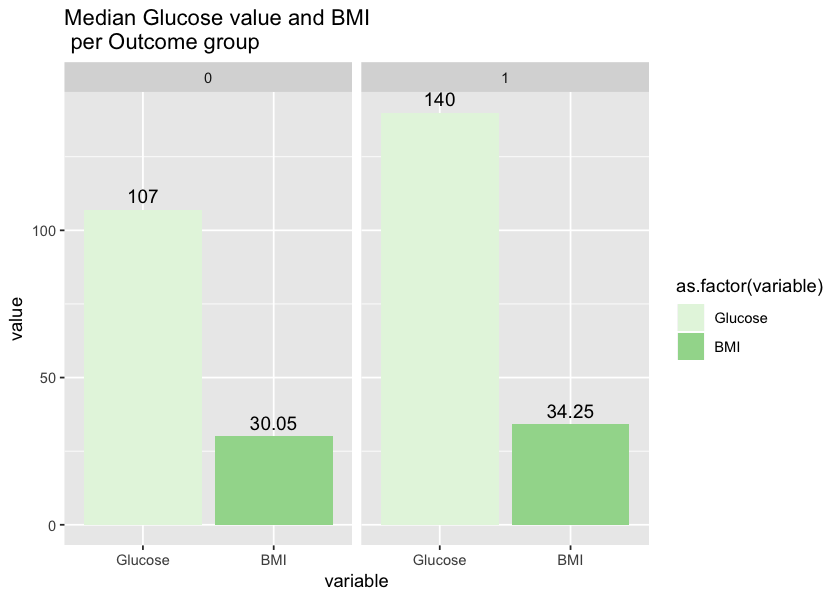

In [16]:
#Mean BMI and Glucose level per Outcome group
medians<-aggregate(df_raw[,c('Glucose','BMI','Outcome')],by=list(df_raw$Outcome),median)
medians<-medians[,2:length(medians)]
medians.long<-melt(medians,id.vars="Outcome")

medians.long
ggplot(medians.long,aes(x=variable,y=value,fill=as.factor(variable))) + facet_wrap(~Outcome) +
    geom_bar(stat="identity",position="dodge") +
    stat_summary(data=medians.long[medians.long$Outcome==0,],aes(label=round(..y..,2)), geom="text", size=4,
             vjust = -0.5,hjust=0.5) +
    stat_summary(data=medians.long[medians.long$Outcome==1,],aes(label=round(..y..,2)),  geom="text", size=4,
             vjust = -0.5,hjust=0.5) +
     scale_fill_brewer(palette="Greens") +
    ggtitle("Median Glucose value and BMI \n per Outcome group") 









Regarding the Body Mass Index, the difference seems low but going from 30.05 to 34.25 is big gap. For the Glucose means, the Glucose indicator is much higher in the sick group than in the non-sick group. 

For both indicators, both the Glucose and BMI indexes are higher in the sick group, which may indicate that the outcome variable may be linked to the individuals' weight. Indeed, obese people have a higher BMI and Glucose values. 

#### PCA

In [17]:
#Let us take a look again at the data to see its structure
head(df_raw)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,agecategory,preg_cat
6,148,72,35,0,33.6,0.627,50,1,3,6
1,85,66,29,0,26.6,0.351,31,0,2,1
8,183,64,0,0,23.3,0.672,32,1,2,7
1,89,66,23,94,28.1,0.167,21,0,1,1
0,137,40,35,168,43.1,2.288,33,1,2,0
5,116,74,0,0,25.6,0.201,30,0,2,5


So we have 8 variables that could explain the outcome variable (we do not take into account our own created "agecategory" and "preg_cat". Let us perform a Principal Component Analysis to see (1) if the variables are very much related (the more correlation the less PC we need to explain most of the variance) and (2) what variables explain the most information. 

In [18]:
df_pca<-prcomp(df_raw[,c(1:8)], center = TRUE,scale. = TRUE)
summary(df_pca)



Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.4472 1.3158 1.0147 0.9357 0.87312 0.82621 0.64793
Proportion of Variance 0.2618 0.2164 0.1287 0.1094 0.09529 0.08533 0.05248
Cumulative Proportion  0.2618 0.4782 0.6069 0.7163 0.81164 0.89697 0.94944
                           PC8
Standard deviation     0.63597
Proportion of Variance 0.05056
Cumulative Proportion  1.00000

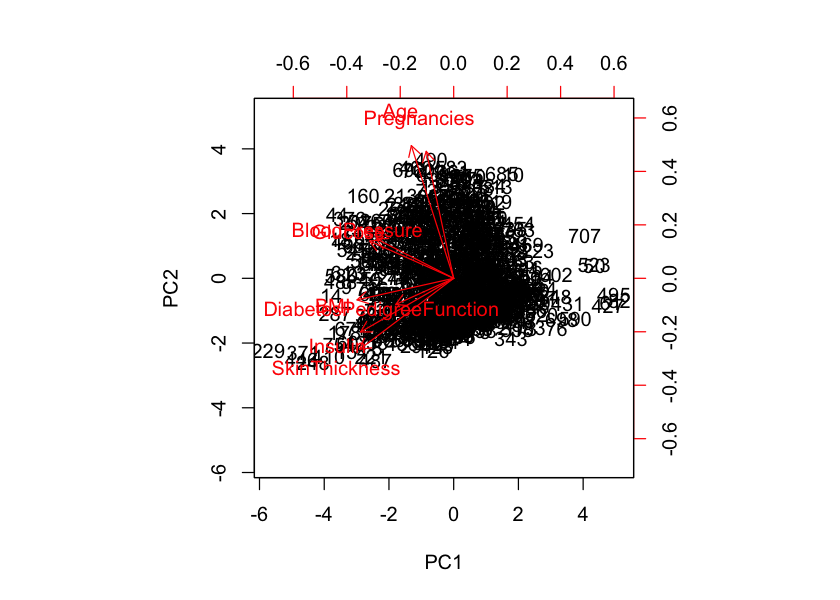

In [11]:
biplot(df_pca, scale = 0)

Principal Components 1 and 2 are the ones that explain most of the variance. From the plot above we can see that PC1 is a measure of SkinThickness and Diabetes, whilst PC2 is a measure of Age and Pregnancies. 

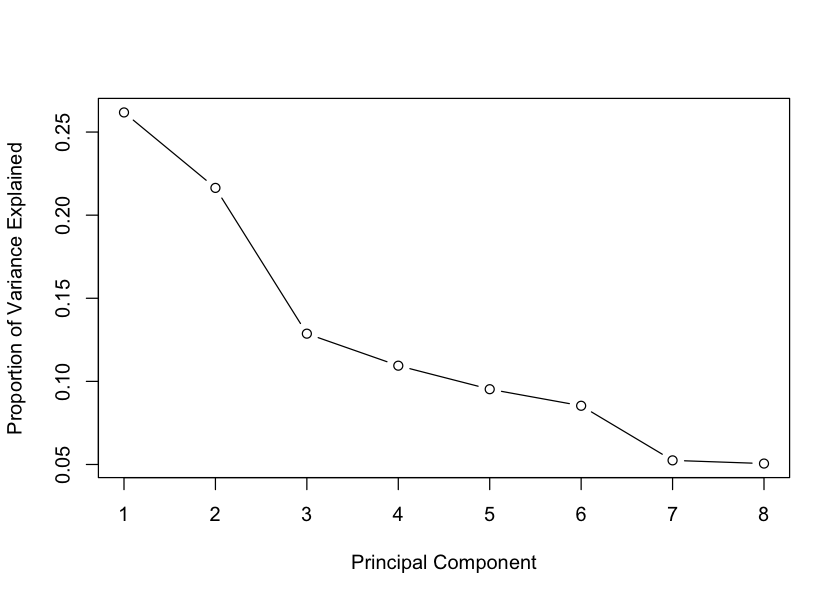

In [19]:
#Plotting a scree plot to see how much information is explained from each PC
std_dev <- df_pca$sdev
pr_var <- std_dev^2
prop_varex <- pr_var/sum(pr_var)
plot(prop_varex, xlab = "Principal Component",
             ylab = "Proportion of Variance Explained",
             type = "b")

We would need to take 6 principal components to explain 85% of the variance. That is a lot. We can conclude that the variables are not very much correlated.  

#### Correlation between 0's and the outcome variable

In [20]:
#Creating a data which takes 1 for each time a zero appears
zeros<-df_raw
zeros$PregnanciesZ<-0;zeros$GlucoseZ<-0;zeros$BPZ<-0;zeros$STZ<-0;zeros$InsulinZ<-0;zeros$BMIZ<-0;
zeros$DiabZ<-0;zeros$AgeZ<-0;

zeros$PregnanciesZ[zeros$Pregnancies==0]<-1
zeros$GlucoseZ[zeros$Glucose==0]<-1
zeros$BPZ[zeros$BloodPressure==0]<-1
zeros$STZ[zeros$SkinThickness==0]<-1
zeros$InsulinZ[zeros$Insulin==0]<-1
zeros$BMIZ[zeros$BMI==0]<-1
zeros$DiabZ[zeros$DiabetesPedigreeFunction==0]<-1
zeros$AgeZ[zeros$Age==0]<-1


In [21]:
zeros2<-zeros[,c('Outcome','PregnanciesZ','GlucoseZ','BPZ','STZ','InsulinZ','BMIZ','DiabZ','AgeZ')]

In [22]:
head(zeros2)

Outcome,PregnanciesZ,GlucoseZ,BPZ,STZ,InsulinZ,BMIZ,DiabZ,AgeZ
1,0,0,0,0,1,0,0,0
0,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,0,0
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
0,0,0,0,1,1,0,0,0


In [23]:
#Aggregate and create table for each value
nbzeros<-aggregate(zeros2[,c(2:length(zeros2))],by=list(zeros2$Outcome),FUN=sum)


In [24]:
nbzeros

Group.1,PregnanciesZ,GlucoseZ,BPZ,STZ,InsulinZ,BMIZ,DiabZ,AgeZ
0,73,3,19,139,236,9,0,0
1,38,2,16,88,138,2,0,0


The table above represents the number of zeros per variable per outcome group. 
We can see that in Outcome=0 group (Group.1=0) we have much more Pregnancies=0 (coherent with previous analysis on pregnancies) and as a general trend there are much more missing values in the non-sick group than in the sick group. 

In [31]:
#Scaling our data without outcome variable
df_pred<-df_raw[,c(1:8)]
df_pred<-scale(df_pred)

In order to know how many clusters we should have, we will use the Elbow method. 

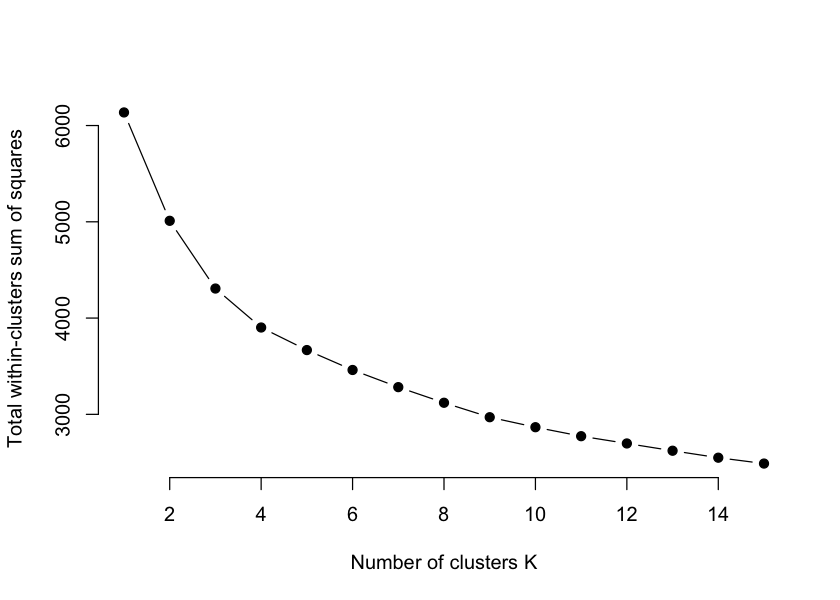

In [32]:
#Defining the within-sum-of-square function 
wss <- function(k) {
  kmeans(df_pred, k, nstart = 10 )$tot.withinss
}

#The within-sum-of-squares function will be computed for k=1 to 15
k.values <- 1:15

# Extracting the within-sum-of-squares for between 2 to 15 clusters
wss_values <- map_dbl(k.values, wss)

#Plotting the within-sum-of-squares for each k-value
plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")

There seems to be a light "elbow" at k=4, we will thus take that k-value. 

In [33]:
#We will use knn clustering method
km.res <- kmeans(df_pred, 4)

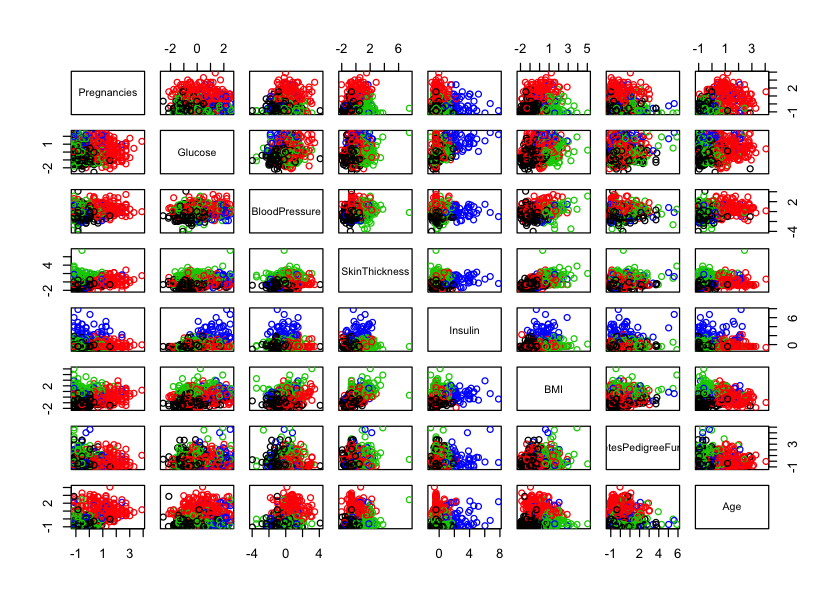

In [34]:
with(df_raw, pairs(df_pred, col=c(1:4)[km.res$cluster])) 

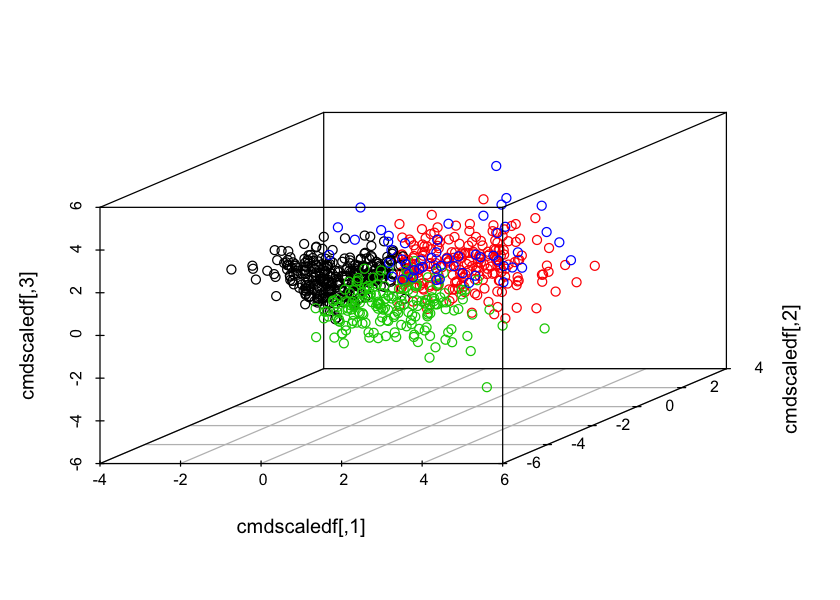

In [35]:
distances <- dist(df_pred, method="euclidean") #compute distances of prediction-data (without outcome)
cmdscaledf <- cmdscale(distances, 3) 
sp3d<-scatterplot3d(cmdscaledf, color=km.res$cluster) #plots the best fitting distance matrix by cluster-colors

The clusters seem to be well delimited and distinct. 

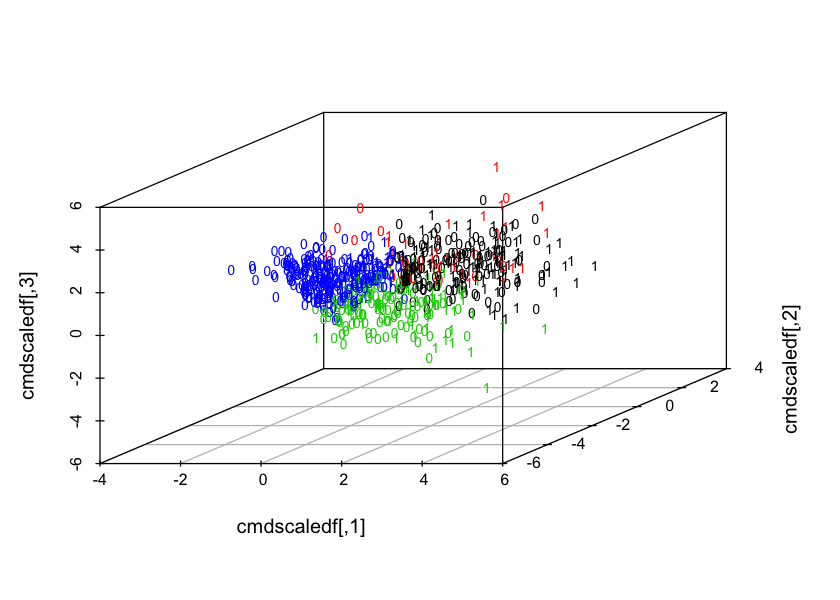

In [95]:
#   Then, represents the value of the outcome variable associated with the obtained clustering.
scatterplot3d(cmdscaledf, color="white") 
text(sp3d$xyz.convert(cmdscaledf), labels = df_raw$Outcome,
     cex= 0.7, col =km.res$cluster)

From the plot above, it looks like the blue cluster has a majority of outcome=0 whilst the black cluster has a majority of outcome=1. Regarding the red and green clusters, they seem to have mixed outcome value, at least at first glance. 

### Supervised classification of the outcome variable.

We will classify the data with CART and then Random Forest

In [36]:
#First we remove our created variables:
df<-df_raw[,c(1:9)]
#This is the data frame on which we will perform classification

In [37]:
#Dividing in train/test set
#Defining sample size as 75% training, 25% testing
samplesize <- floor(0.75 * nrow(df))
set.seed(12345) #set seed to get same results each time
train_index <- sample(seq_len(nrow(df)), size = samplesize)
training_data<-df[train_index,]
testing_data<-df[-train_index,]
levels(training_data$Outcome) <- c("Not_sick", "Sick")

In [38]:
tree1<-rpart(Outcome~., data=df, method="class",control=) 

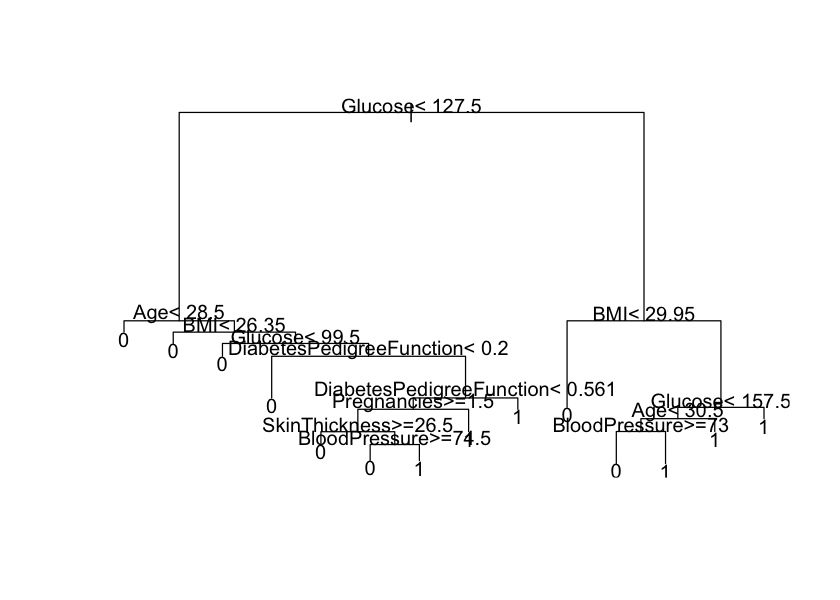

In [39]:
#Plotting the tree
plot(tree1)
text(tree1)

In [40]:
#Let us see how well it did in terms of accuracy. We will plot the confusion matrix
tab<-table(predict(tree1, testing_data, type = "class"), testing_data$Outcome)
tab

   
      0   1
  0 100  16
  1  14  62

We can conclude that it performs pretty well as it has an accuracy of around 84,38% (=(62+100)/(62+100+14+16))

In [41]:
#Random Forest
rf1 <- randomForest(Outcome~., data=df)
print(rf1) # view results 
importance(rf1)


Call:
 randomForest(formula = Outcome ~ ., data = df) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 23.44%
Confusion matrix:
    0   1 class.error
0 423  77   0.1540000
1 103 165   0.3843284


,MeanDecreaseGini
Pregnancies,28.22843
Glucose,91.02393
BloodPressure,30.28191
SkinThickness,25.02573
Insulin,27.03461
BMI,56.05335
DiabetesPedigreeFunction,43.13856
Age,46.83067


The three most important variables for predicting the outcome variable are, in ascending order, 
    1. Glucose
    2. BMI
    3. Age
    